This application takes two images as input and outputs the probablility that they are the same image

# Imports

In [282]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import cv2
import os
import numpy as np
import random
from random import randrange


### settings

In [257]:
verbose = 0
negative_images_per_pos_image = 10

# Load Data

torch.Size([32, 32, 3])


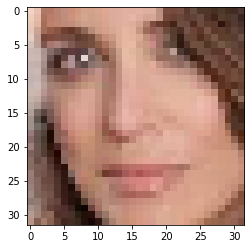

In [459]:
def load_image_to_tensor(src):
    img = image.imread(src)
    resize = cv2.resize(img, (32, 32))
    tensor = torch.tensor(resize)
    # put in N Channel Height Width format!
    permute = tensor.permute(2,0,1)
    return permute


# image_a = load_image_to_tensor('TestData/testA0.jpg')
image_b = load_image_to_tensor('CroppedDataset/AlannaUbach/download-4.jpg')

# print(image_a.shape)

# plt.imshow(image_a)
# plt.imshow(image_b)

# r = torchvision.transforms.Resize((256))
# t = torchvision.transforms.ToTensor()
# resized = r(image_a)
# resized = t(resized)

# r = cv2.resize(image_b, (128,128))
# r = torch.tensor(r)
# print(r.shape)
print(image_b.permute(1,2,0).shape)
plt.imshow(image_b.permute(1,2,0))

plt.show()



In [460]:
bastian0 = load_image_to_tensor('TestData/bastian0.jpg')
bastian1 = load_image_to_tensor('TestData/bastian1.jpg')

clinton0 = load_image_to_tensor('TestData/clinton0.jpg')
clinton1 = load_image_to_tensor('TestData/clinton1.jpg')
clinton2 = load_image_to_tensor('TestData/clinton2.jpg')

dobrik0 = load_image_to_tensor('TestData/dobrik0.jpg')
dobrik1 = load_image_to_tensor('TestData/dobrik1.jpg')
dobrik2 = load_image_to_tensor('TestData/dobrik2.jpg')

jassy0 = load_image_to_tensor('TestData/jassy0.jpg')
jassy1 = load_image_to_tensor('TestData/jassy1.jpg')
jassy2 = load_image_to_tensor('TestData/jassy2.jpg')
jassy3 = load_image_to_tensor('TestData/jassy3.jpg')


## Display an Image

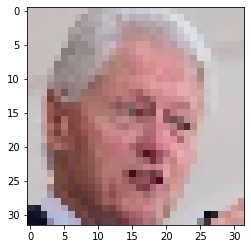

In [461]:
plt.imshow(clinton2.permute(1,2,0))
plt.show()

# Define Network

In [480]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 5, padding = 3)
        self.a1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 4)
        #norm???
        # layer 2
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 5, padding = 3)
        self.a2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 4)
        # layer 3
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 3)
        self.a3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 4)
        #linear
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = 32, out_features = 16)
        self.a4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features = 16, out_features = 1)



    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = self.a1(x)
        x = self.pool1(x)
        # layer 2
        x = self.conv2(x)
        x = self.a2(x)
        x = self.pool2(x)
        #layer 3
        x = self.conv3(x)
        x = self.a3(x)
        x = self.pool3(x)
        #linear
        x = self.flatten(x)
#         print(x.shape)
        x = self.fc1(x)
        x = self.a4(x)
        x = self.fc2(x)
        return(x)

net = Net()

# net = nn.Sequential(
#         nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 8),
#         nn.Flatten(),
#         nn.Linear(in_features = 32*4, out_features = 1)
#     )
    

        

In [470]:
def single_image_forward_pass(img_a, img_b):
    cat = torch.cat((img_a, img_b), dim = 2)
    us = torch.unsqueeze(cat, 0)
    out = net(us.float())
    return out

    
def make_input(img_a, img_b):
    cat = torch.cat((img_a, img_b), dim = 2)
    return cat

# print(single_image_forward_pass(jassy0, jassy1))

## Test single_image_forward_pass

In [471]:
print(single_image_forward_pass(jassy0, jassy1).detach().numpy()[0])


torch.Size([1, 32])
[1.1037612]


## Test load_image_to_tensor and make_input

torch.Size([64, 128, 3])


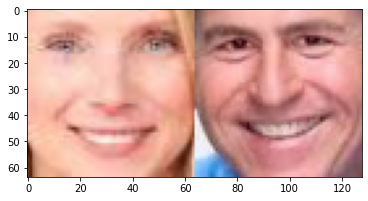

tensor([247, 192, 171], dtype=torch.uint8)


In [321]:
img0 = load_image_to_tensor(data_dir + '/MarissaMayer/download.jpg')
img1 = load_image_to_tensor(data_dir + '/MichaelDell/download-4.jpg')

e = make_input(img0, img1).permute(1,2,0)
print(e.shape)

plt.imshow(e)
plt.show()

print(e[1][0])


## create data

In [354]:
inputs = torch.stack([
        make_input(jassy0, jassy1),#1
        make_input(jassy1, jassy0),#1
        make_input(jassy2, jassy1),#1
        make_input(jassy0, clinton1),#0
        make_input(clinton0, clinton1),#1
        make_input(clinton2, jassy1),#0
        make_input(bastian0, bastian1),#1
        make_input(bastian1, clinton0),#0
        make_input(jassy0, bastian0),#0
        make_input(jassy0, bastian1),#0
        ])
labels = torch.tensor([1,1,1,0,1,0,1,0,0,0])
print('x shape: ' + str(inputs.shape))
print('y shape: ' + str(labels.shape))

x shape: torch.Size([10, 3, 64, 128])
y shape: torch.Size([10])


## Train network

In [355]:
#net = Net()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters())
loss_history = []

torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])


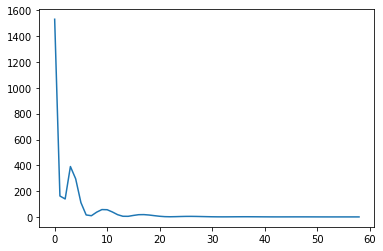

In [360]:

for epoch in range(20):
    outputs = net(inputs.float()).reshape(-1)
#     print('labels: ' + str(labels))
#     print('predicitons: ' + str(outputs))
    
    loss = criterion(outputs.float(), labels.float())
    net.zero_grad()
    loss.backward()
    
    optimizer.step()
    loss_history.append(loss)
#     print("Loss: " + str(loss))
plt.plot(loss_history[1:])
plt.show()

# print(loss_history)
    
    

## test a couple of examples

In [361]:
print('positive example jassy0 and jassy1 (1): ' + str(single_image_forward_pass(jassy0, jassy1).detach().numpy()[0]))
print('negative example bastian1, clinton0 (0): ' + str(single_image_forward_pass(bastian1, clinton0).detach().numpy()[0]))

torch.Size([1, 128])
positive example jassy0 and jassy1 (1): [0.72633094]
torch.Size([1, 128])
negative example bastian1, clinton0 (0): [0.00991932]


## Test

In [664]:
p = single_image_forward_pass(bastian1, clinton0)#.detach().numpy()[0]
p = nn.Tanh()(p).detach().numpy()[0]
print('positive example (1): ' + str(p))


positive example (1): [-0.00539827]


In [593]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()




torch.Size([3])
torch.Size([3, 5])


# Large Dataset

## Load file names into dataset dictionary

In [175]:
data_dir = 'CroppedDataset'

people = os.listdir(data_dir)

if verbose:
    print('---Identified ' + str(len(people)) + ' Labeled People---')

#remove .DS_Store and other hidden files
for filename in people:
    if '.' in filename:
        people.remove(filename)
        
dataset = {}
example_count = 0
        
for person in people:
    files = os.listdir(data_dir + '/' + person)
    examples = []
    for e in files:
        if '.DS' not in e:
            examples.append(data_dir + '/' + person + '/' + e)
    if '.' not in person:
        dataset[person] = examples
        example_count += len(examples)
        if verbose:
            print('Loaded ' + str(len(examples)) + ' examples of ' + person)

if verbose:
    print('---Loaded ' + str(example_count) + ' Total Examples---')

print(dataset['JoeRogan'])

['CroppedDataset/JoeRogan/download.jpg', 'CroppedDataset/JoeRogan/images-4.jpg', 'CroppedDataset/JoeRogan/images-5.jpg', 'CroppedDataset/JoeRogan/images-1.jpg', 'CroppedDataset/JoeRogan/images-2.jpg', 'CroppedDataset/JoeRogan/images-3.jpg', 'CroppedDataset/JoeRogan/download-3.jpg', 'CroppedDataset/JoeRogan/download-2.jpg', 'CroppedDataset/JoeRogan/download-1.jpg', 'CroppedDataset/JoeRogan/download-5.jpg', 'CroppedDataset/JoeRogan/download-4.jpg', 'CroppedDataset/JoeRogan/images.jpg']


## Create X of filenames and Y

In [475]:
print('---Generating Examples---')

train_x = torch.Tensor([])
train_y = torch.Tensor([])

test_x = torch.Tensor([])
test_y = torch.Tensor([])

dev_x = torch.Tensor([])
dev_y = torch.Tensor([])



for person_key in dataset.keys():
    if verbose:
        print('---' + person_key + '---')
    for example_filename in dataset[person_key]:
        filename = data_dir + '/' + example_filename
        if verbose:
            print(filename)
        #create positive examples
        
        
        #create negative examples


def generate_examples_for_person(dataset, key):
    
    # get positive images
    positive_images = dataset[key]
    
    # get negative images
    dataset_keys = list(dataset.keys())
    dataset_keys.remove(key)
    negative_images = []

    for k in dataset_keys:
        negative_images = negative_images + dataset[k]
    # define outputs
    x = torch.Tensor([])
    y = torch.Tensor([])
    
    #generate examples
    for first_image_filename in positive_images:
        current_image = load_image_to_tensor(first_image_filename)
        # match each image with another positive image
        for second_image_filename in positive_images:
            
#             first_image_filename = first_image_name
#             second_image_filename = second_image_name
            

            second_image = load_image_to_tensor(second_image_filename)
            
            positive_example = make_input(current_image, second_image)
            
            if verbose:
                print('\033[1mPositve Example\033[0m')
                plt.imshow(positive_example.permute(1,2,0))
                plt.show()
            
            x = torch.cat((x, positive_example.unsqueeze(0)))
            y = torch.cat((y, torch.Tensor([1])))
            
        # match each image with a couple negative example
        for i in range(negative_images_per_pos_image):
            random_negative_image_filename = negative_images[randrange(len(negative_images))]
            random_negative_image = load_image_to_tensor(random_negative_image_filename)
            negative_example = make_input(current_image, random_negative_image)
            
            if verbose:
                print('\033[1mNegative Example\033[0m')
                plt.imshow(negative_example.permute(1,2,0))
                plt.show()
            
            x = torch.cat((x, negative_example.unsqueeze(0)))
            y = torch.cat((y, torch.Tensor([0])))
        
    return x, y


number_of_people = len(dataset.keys())

for key in dataset.keys():
    print('--Generting Examples for ' + key + '--')
    x, y = generate_examples_for_person(dataset, key)
    
    rand = random.uniform (0, 1)
    
    if rand < 0.7:
        train_x = torch.cat((train_x, x))
        train_y = torch.cat((train_y, y))
    elif rand < 0.85:
        test_x = torch.cat((test_x, x))
        test_y = torch.cat((test_y, y))
    else:
        dev_x = torch.cat((dev_x, x))
        dev_y = torch.cat((dev_y, y))
    
print('---Generated ' + str(train_x.shape[0]) + ' Training Examples---')


---Generating Examples---
--Generting Examples for MikePence--
--Generting Examples for AndersonCooper--
--Generting Examples for AmyKlobuchar--
--Generting Examples for RicardoForster--
--Generting Examples for DaraKhosrowshahi--
--Generting Examples for CalebMclaughlin--
--Generting Examples for MichaelBloomberg--
--Generting Examples for BenShephard--
--Generting Examples for EdBastian--
--Generting Examples for GailCollins--
--Generting Examples for JasonDerulo--
--Generting Examples for AliciaSilverstone--
--Generting Examples for NishaGuragain--
--Generting Examples for KaraSwisher--
--Generting Examples for AlexandraDaddario--
--Generting Examples for NatalieNoel--
--Generting Examples for PeirsMorgan--
--Generting Examples for JohnMcCain--
--Generting Examples for MalaniaTrump--
--Generting Examples for RandPaul--
--Generting Examples for TigerWoods--
--Generting Examples for CharlieDamelio--
--Generting Examples for AnthonyFauci--
--Generting Examples for JustinBieber--
--Gene

## Browse Examples

Train X shape: torch.Size([10128, 3, 32, 64])
Train Y shape: torch.Size([10128])
torch.Size([32, 64, 3])
Negative Example 


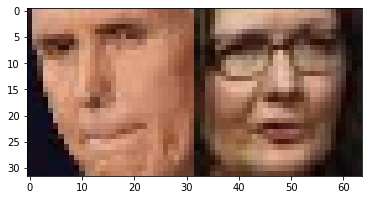

tensor([202, 159, 156], dtype=torch.int32)


In [476]:
example_index = 112


print('Train X shape: ' + str(train_x.shape))
print('Train Y shape: ' + str(train_y.shape))
img = train_x[example_index].permute(1,2,0).int()
print(img.shape)
plt.imshow(img)
print('\033[1mPositive Example \033[0m' if train_y[example_index] == 1 else '\033[1mNegative Example \033[0m')
plt.show()
print(img[0][1])



#### Shuffle Each Set

In [ ]:
#todo

## Train on Full Dataset
### Reset

In [477]:
net = Net()

### Prepare

In [478]:
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters())
loss_history = []

### Train

In [482]:

# num_mini_batches = 50
# num_examples = train_x.shape[0]
# mb_size = num_examples / num_mini_batches - 5
t_x = train_x
t_y = train_y

for epoch in range(100):
    print('--Start Epoch ' + str(epoch) + '--')
    
#     for mb in range(10):
#         print('---Mini-Batch ' + str(mb) + '---')
#         t_x = train_x[mb * mb_size:(mb + 1) * mb_size]
#         t_y = trian_y[mb * mb_size:(mb + 1) * mb_size]
#         t_x = t_x.cat((t_x, train_x[(mb + 1) * mb_size:]))
#         t_y = t_x.cat((t_x, train_x[(mb + 1) * mb_size:]))
        
#         print(t_x.shape)
        
    outputs = net(t_x.float()).reshape(-1)
    loss = criterion(outputs.float(), t_y.float())
    net.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss)
    
    
    print('--End Epoch ' + str(epoch) + ' Loss ' + str(loss) + '--')
    
# plt.plot(loss_history[1:])
# plt.show()

# print(loss_history)

--Start Epoch 0--
--End Epoch 0 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 1--
--End Epoch 1 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 2--
--End Epoch 2 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 3--
--End Epoch 3 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 4--
--End Epoch 4 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 5--
--End Epoch 5 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 6--
--End Epoch 6 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 7--
--End Epoch 7 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 8--
--End Epoch 8 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 9--
--End Epoch 9 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 10--
--End Epoch 10 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoch 11--
--End Epoch 11 Loss tensor(309012., grad_fn=<MseLossBackward>)--
--Start Epoc

KeyboardInterrupt: 

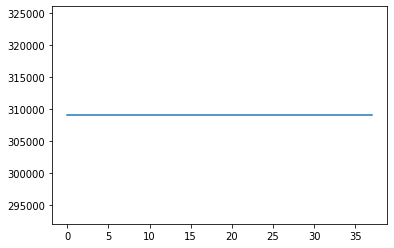

In [483]:
plt.plot(loss_history[1:])
plt.show()

### Examples
#### Dev

In [448]:
print('dev_x: ' + str(dev_x.shape))
print('dev_y: ' + str(dev_y.shape))

dev_x: torch.Size([1451, 3, 64, 128])
dev_y: torch.Size([1451])


torch.Size([64, 128, 3])
Positive Example 
0.054596633


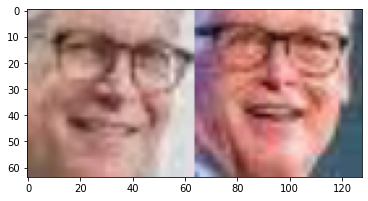

In [449]:
example_index = 134

img = dev_x[example_index].permute(1,2,0).int()
print(img.shape)
plt.imshow(img)
print('\033[1mPositive Example \033[0m' if dev_y[example_index] == 1 else '\033[1mNegative Example \033[0m')
pred = net(dev_x[example_index].unsqueeze(0))
print(pred.detach().numpy()[0][0])
plt.show()



#### Train

In [450]:
print('train_x: ' + str(train_x.shape))
print('train_y: ' + str(train_y.shape))

train_x: torch.Size([10884, 3, 64, 128])
train_y: torch.Size([10884])


torch.Size([64, 128, 3])
Positive Example
0.0501419


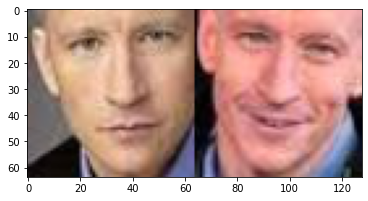

In [458]:
example_index = 141

img = train_x[example_index].permute(1,2,0).int()
print(img.shape)
plt.imshow(img)
print('\033[1mPositive Example\033[0m' if train_y[example_index] == 1 else '\033[1mNegative Example\033[0m')
pred = net(train_x[example_index].unsqueeze(0))
print(pred.detach().numpy()[0][0])
plt.show()
